# Conversation Trajectory

In [1]:
import os
import re
import sys
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('..')

from utils.pca_utils import L2MeanScaler, MeanScaler, compute_pca, plot_variance_explained


In [2]:
plt.style.use('./arena.mplstyle')

# Color palette for PC lines
PC_COLORS = [
    '#4a6fa5',  # muted blue
    '#c4a5a5',  # dusty rose
    '#7d9a78',  # sage green
    '#6b7b8c',  # slate
    '#b8977e',  # clay
    '#1a1a1a',  # charcoal
]

# Gradient background colormap (red = role-playing, blue = assistant-like)
from matplotlib.colors import Normalize, LinearSegmentedColormap
CMAP_RED_BLUE = LinearSegmentedColormap.from_list('RedBlue', ['#e63946', '#457b9d'])


class ThresholdNorm(Normalize):
    """Normalize with a threshold - values above threshold map to 1.0 (blue)."""
    
    def __init__(self, vmin, threshold):
        if vmin >= threshold:
            vmin = threshold - 1.0
        super().__init__(vmin=vmin, vmax=threshold)
        self.threshold = threshold
    
    def __call__(self, value, clip=None):
        return super().__call__(value, clip=True)


def add_gradient_background(ax, x_range, y_range, threshold=0, vmin=None, alpha=0.3):
    """Add a vertical gradient background based on y-axis values.
    
    Blue = assistant-like (at or above threshold)
    Red = role-playing (below threshold)
    """
    gradient = np.linspace(y_range[0], y_range[1], 256).reshape(-1, 1)
    
    if vmin is None:
        vmin = y_range[0]
    
    norm = ThresholdNorm(vmin=vmin, threshold=threshold)
    
    ax.imshow(gradient, aspect='auto', cmap=CMAP_RED_BLUE,
              extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
              origin='lower', norm=norm, zorder=0, alpha=alpha)

In [3]:
model = "qwen-3-32b"
auditor_model = "gpt-5"
layer = 32

acts_input_dir = f"/workspace/{model}/dynamics/{auditor_model}/default/activations"

In [8]:
domains = ["coding", "writing", "philosophy", "therapy"]

# Load precomputed mean activations
instruct = {}
for domain in domains:
    data = torch.load(f"{acts_input_dir}/{domain}_mean.pt", weights_only=False, map_location="cpu")
    instruct[domain] = data['mean_acts']
    print(f"{domain}: {instruct[domain].shape}")

coding: torch.Size([30, 5120])
writing: torch.Size([30, 5120])
philosophy: torch.Size([30, 5120])
therapy: torch.Size([30, 5120])


In [9]:
role_results = torch.load(f"/workspace/{model}/roles_240/pca/layer{layer}_mean_pos23.pt", weights_only=False)

# Load contrast vector and replace PC1 with it
contrast_vector = torch.load(f"/workspace/{model}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0)  * -1 # normalize
#role_results['pca'].components_[0] *= -1  # replace PC1
role_results['pca'].components_[0] = contrast_vector.float()  # replace PC1

def pc_projection(mean_acts_per_turn, pca_results, n_pcs=8):
    """Project activations onto principal components (with scaling)."""
    if isinstance(mean_acts_per_turn, list):
        stacked_acts = torch.stack(mean_acts_per_turn)
    else:
        stacked_acts = mean_acts_per_turn
    stacked_acts = stacked_acts.float().numpy()
    scaled_acts = pca_results['scaler'].transform(stacked_acts)
    projected_acts = pca_results['pca'].transform(scaled_acts)
    return projected_acts[:, :n_pcs]

/tmp/ipykernel_3495666/502243241.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  role_results['pca'].components_[0] = contrast_vector.float()  # replace PC1


In [10]:
# Project assistant turns only (odd indices) onto PCs
# PC1 is now the contrast vector, PC2 and PC3 are original PCs
role_domain_projs = {
    domain: pc_projection(instruct[domain][1::2], role_results, n_pcs=3)
    for domain in domains
}

role_pc_titles = [
    'Role-playing ↔ Assistant-like',
    'Collective ↔ Individual',
    'Empathetic ↔ Blunt'
]

# Display names and order for the 2x2 grid (change these as needed)
domain_display = {
    "coding": "Coding",
    "writing": "Writing",
    "philosophy": "Philosophy",
    "therapy": "Therapy",
}
domain_order = ["coding", "philosophy", "writing", "therapy"]

In [11]:
def plot_trajectory_grid(domain_projs, domain_order, domain_display, pc_titles,
                         figsize=(7, 5), shade_threshold=0, shade_alpha=0.3):

    """Create a 2x2 grid of trajectory plots with shared y-axis and gradient background.

    Parameters:
    - domain_projs: Dict mapping domain names to projection matrices
    - domain_order: List of domain keys in display order (row-major)
    - domain_display: Dict mapping domain keys to display names
    - pc_titles: List of PC titles for the legend
    - figsize: figure size tuple
    - shade_threshold: y-value where gradient transitions (blue above, red below)
    - shade_alpha: transparency of gradient background
    """
    # Compute global y-range across all domains
    all_y = np.concatenate([domain_projs[d].flatten() for d in domain_order])
    y_min, y_max = np.nanmin(all_y), np.nanmax(all_y)
    y_pad = (y_max - y_min) * 0.1
    y_range = (y_min - y_pad, y_max + y_pad)

    # Compute global x-range
    max_turns = max(domain_projs[d].shape[0] for d in domain_order)
    x_range = (0-0.5, max_turns-0.5)


    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, domain in enumerate(domain_order):
        ax = axes[idx]
        mat = domain_projs[domain]
        n_turns, n_pcs = mat.shape
        turn_indices = np.arange(n_turns)

        # # Add gradient background
        # add_gradient_background(ax, x_range, y_range,
        #                         threshold=shade_threshold, alpha=shade_alpha)

        # Plot each PC as a line (matching fig5-6 styling)
        for pc_idx in range(n_pcs):
            projections = mat[:, pc_idx]
            color = PC_COLORS[pc_idx % len(PC_COLORS)]

            ax.plot(turn_indices, projections,
                    color=color,
                    marker='o',
                    markersize=4,
                    linewidth=1)

        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])

        # Ensure bounding box on all sides
        for spine in ax.spines.values():
            spine.set_visible(True)

        if idx % 2 == 0:
            ax.set_ylabel('Projection', fontsize=10)
        ax.set_title(domain_display.get(domain, domain.capitalize()), fontsize=12)

    axes[2].set_xlabel('Conversation Turn', fontsize=10)
    axes[3].set_xlabel('Conversation Turn', fontsize=10)


    plt.tight_layout()

    # Create vertical legend on the right with arrows inline
    # Parse pc_titles to get low/high labels (format: "Low ↔ High")
    legend_elements = []
    legend_labels = []
    for pc_idx, title in enumerate(pc_titles):
        parts = title.split(' ↔ ')
        low_label, high_label = parts[0], parts[1]
        color = PC_COLORS[pc_idx % len(PC_COLORS)]
        
        # Create a line element for the legend
        line = plt.Line2D([0], [0], color=color, marker='o', markersize=4, linewidth=1)
        legend_elements.append(line)
        # Format: "↑ High / ↓ Low"
        legend_labels.append(f'↑ {high_label}\n↓ {low_label}')

    # Add legend to the right of the plots (with rounded edges)
    fig.legend(legend_elements, legend_labels,
               loc='center right',
               bbox_to_anchor=(1.0, 0.5),
               ncol=1,
               fontsize=8,
               frameon=True,
               edgecolor='lightgray',
               fancybox=True,
               handlelength=1.5,
               labelspacing=1.2)

    # Adjust layout to make room for legend on right
    fig.subplots_adjust(right=0.78)

    return fig

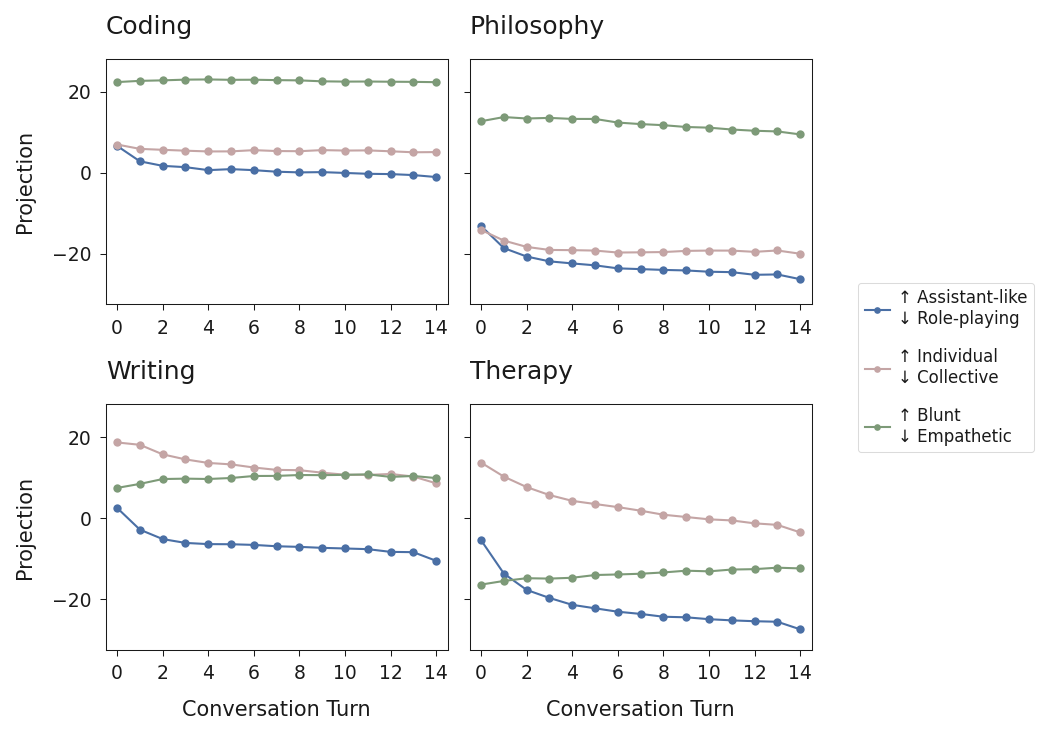

In [12]:
# shade_threshold computed from role/trait projections (blue above, red below)
fig = plot_trajectory_grid(
    role_domain_projs, domain_order, domain_display, role_pc_titles
)
plt.show()

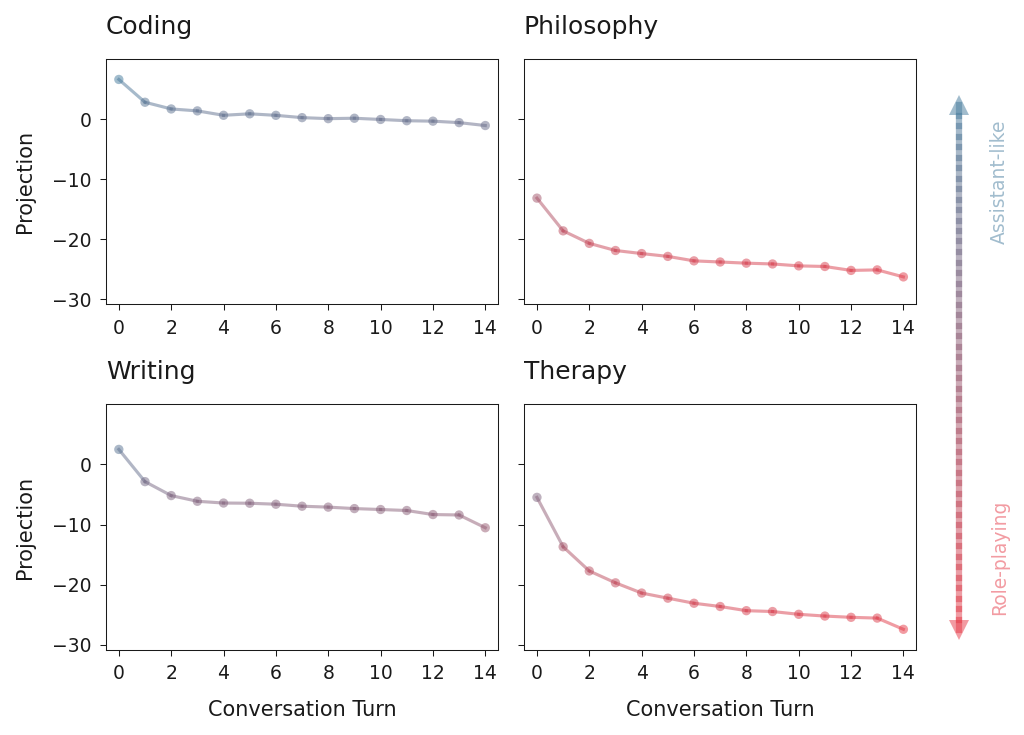

In [ ]:
def plot_contrast_trajectory_gradient(domain_projs, domain_order, domain_display,
                                       figsize=(7, 5)):
    """Create a 2x2 grid showing only the contrast vector projection with gradient coloring.
    
    Line and markers are colored on a red-to-blue gradient based on y-axis value.
    Legend is shown as big annotations with arrows.
    """
    # Extract only PC1 (contrast vector) for all domains
    contrast_projs = {d: domain_projs[d][:, 0] for d in domain_order}
    
    # Compute global y-range across all domains for consistent coloring
    all_y = np.concatenate([contrast_projs[d] for d in domain_order])
    y_min, y_max = np.nanmin(all_y), np.nanmax(all_y)
    y_pad = (y_max - y_min) * 0.1
    y_range = (y_min - y_pad, y_max + y_pad)
    
    # Normalization for color mapping
    norm = Normalize(vmin=y_min, vmax=y_max)
    
    # Compute global x-range
    max_turns = max(contrast_projs[d].shape[0] for d in domain_order)
    x_range = (0-0.5, max_turns-0.5)

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, domain in enumerate(domain_order):
        ax = axes[idx]
        projections = contrast_projs[domain]
        n_turns = len(projections)
        turn_indices = np.arange(n_turns)
        
        # Plot line segments with gradient colors
        for i in range(n_turns - 1):
            # Color based on average y-value of segment
            y_avg = (projections[i] + projections[i+1]) / 2
            color = CMAP_RED_BLUE(norm(y_avg))
            ax.plot([turn_indices[i], turn_indices[i+1]], 
                    [projections[i], projections[i+1]],
                    color=color, linewidth=1.5, alpha=0.5, zorder=1)
        
        # Plot markers with gradient colors based on their y-value
        for i in range(n_turns):
            color = CMAP_RED_BLUE(norm(projections[i]))
            ax.scatter(turn_indices[i], projections[i], 
                       c=[color], s=20, alpha=0.5, zorder=2, edgecolors='none')

        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])

        for spine in ax.spines.values():
            spine.set_visible(True)

        if idx % 2 == 0:
            ax.set_ylabel('Projection', fontsize=10)
        ax.set_title(domain_display.get(domain, domain.capitalize()), fontsize=12)

    axes[2].set_xlabel('Conversation Turn', fontsize=10)
    axes[3].set_xlabel('Conversation Turn', fontsize=10)

    plt.tight_layout()
    fig.subplots_adjust(right=0.88)
    
    # Arrow position in figure coordinates
    arrow_x = 0.92
    arrow_bottom = 0.15
    arrow_top = 0.85
    
    # Draw gradient line as multiple segments
    n_segments = 50
    for i in range(n_segments):
        y0 = arrow_bottom + i * (arrow_top - arrow_bottom) / n_segments
        y1 = arrow_bottom + (i + 1) * (arrow_top - arrow_bottom) / n_segments
        # Color from red (bottom) to blue (top)
        color = CMAP_RED_BLUE(i / n_segments)
        fig.add_artist(plt.Line2D([arrow_x, arrow_x], [y0, y1], 
                                   color=color, linewidth=3, alpha=0.5,
                                   transform=fig.transFigure, zorder=10))
    
    # Add arrowhead at top (blue)
    fig.add_artist(plt.Line2D([arrow_x], [arrow_top], marker='^', markersize=10,
                               color='#457b9d', alpha=0.5, transform=fig.transFigure,
                               linestyle='none', zorder=11))
    
    # Add arrowhead at bottom (red)
    fig.add_artist(plt.Line2D([arrow_x], [arrow_bottom], marker='v', markersize=10,
                               color='#e63946', alpha=0.5, transform=fig.transFigure,
                               linestyle='none', zorder=11))
    
    # Add rotated text labels at each end
    fig.text(arrow_x + 0.03, arrow_top - 0.02, 'Assistant-like', fontsize=9, color='#457b9d',
             ha='left', va='top', fontweight='medium', rotation=90, alpha=0.5)
    fig.text(arrow_x + 0.03, arrow_bottom + 0.02, 'Role-playing', fontsize=9, color='#e63946',
             ha='left', va='bottom', fontweight='medium', rotation=90, alpha=0.5)

    return fig


# Generate the gradient contrast plot
fig_contrast = plot_contrast_trajectory_gradient(
    role_domain_projs, domain_order, domain_display
)
plt.show()